In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from scipy.optimize import curve_fit
from scipy.stats import norm

_plot_params = 0
def plot_init( numrows, numcols, axis = True ):
    plt.figure( figsize = ( numcols * 6, numrows * 4  ) )
    global _plot_params
    _plot_params = [ numrows, numcols, 0 ]
    if( axis ):
        plot_next()
def plot_next():
    _plot_params[2] += 1
    plt.subplot( *_plot_params )

In [2]:
# Data origin
path = "../CloudVenetoAnalysis/20220415LowResSquaredWidescan_20220415/f_3"

In [3]:
# Load data
data = []
with open( path + "/chunks.txt" ) as file:
    lines = file.readlines()

data = []
for line in lines[1:]:
    data.append( json.loads( "[" + line.replace(",]","]") + "]" ) )

def datac( i ):
    return [ d[i] for d in data ];

# for line in lines:
#     numbers

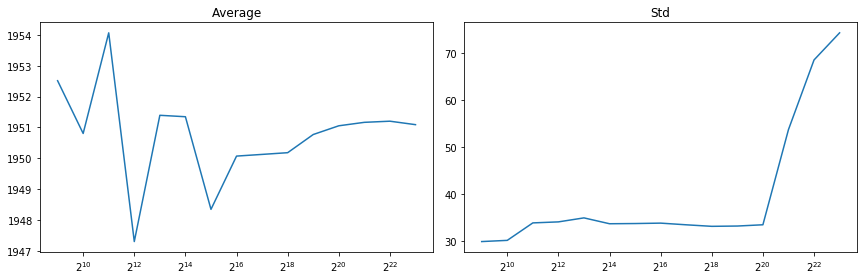

In [4]:
plot_init( 1, 3 )

def computed_avg():
    return [ np.mean( d[3] ) for d in data ]

plt.semilogx( datac(0), computed_avg(), basex = 2 )
plt.title( 'Average' )

plot_next();

plt.semilogx( datac(0), datac(1), basex = 2 )

# def computed_std():
    # return [ np.std( d[3] ) for d in data ]

# plt.semilogx( datac(0), computed_std(), basex = 2 )
plt.title( 'Std' )

# plot_next();

# plt.semilogx( datac(0)[4:], np.array(datac(2)[4:]) - 1, basex = 2 )

# # def computed_var():
# #     return [ max( computed_std()[i-4:i] ) / min( computed_std()[i-4:i] ) for i in range(4,len(data)) ]

# # plt.semilogx( datac(0)[3:-1], computed_var(), basex = 2 )
# plt.title( 'Relative variation' )

plt.savefig('AverageAndStd.pdf')

plt.tight_layout()

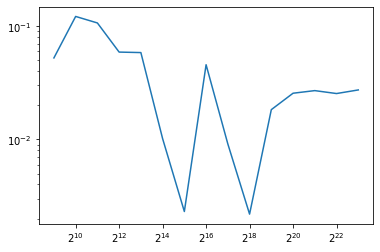

In [5]:
from scipy.stats import kurtosis
plt.loglog( datac(0), [ abs( kurtosis( d[3]) ) for d in data ], basex = 2 )

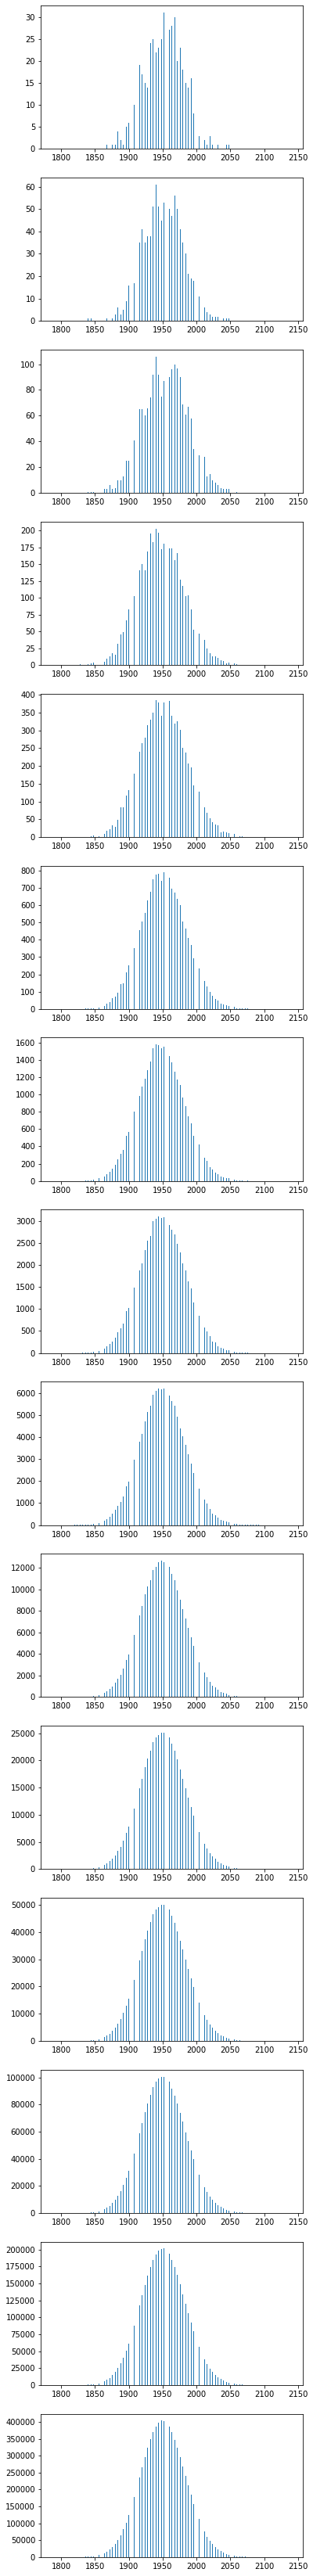

In [6]:
plot_init( len(data), 1, False )

bins = np.arange( min( data[-1][3] ), max( data[-1][3] ) + 1 ) - 0.5

gauss = []

for d in data:
    if( d[0] > 2e10 ):
        continue
    plot_next()
    h, _, _ = plt.hist( d[3], bins = bins )
    gauss.append( {
        'x': bins[:-1][ h > 0 ],
        'y': h[ h > 0 ] / d[0]
    })

(142600, 142800)

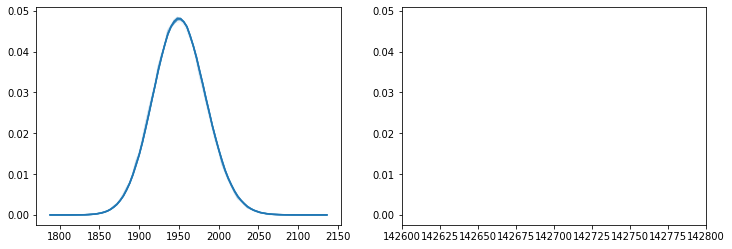

In [8]:
bins = np.arange( min( data[-1][3] ) / 4, (max( data[-1][3] ) + 4) / 4 ) * 4 - 2
hists = []
for d in data:
    h, _ = np.histogram( d[3], bins=bins )
    hists.append( h / d[0] )
bins = bins[:-1]+2

plot_init( 1, 2 )

for i_d,d in enumerate( data ):
    if( i_d < 8 ):
        continue
    plt.plot( bins, hists[i_d], color='tab:blue', alpha= 1 - ( 1 - i_d /len( data ) ) * 2 )

plot_next()
for i_d,d in enumerate( data ):
    if( i_d < 8 ):
        continue
    plt.plot( bins, hists[i_d], color='tab:blue', alpha= 1 - ( 1 - i_d /len( data ) ) * 2 )
plt.xlim( 142600, 142800 )

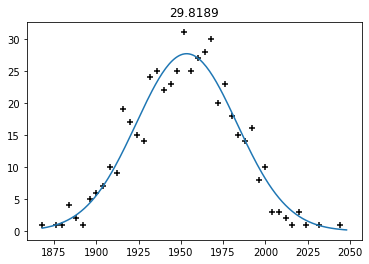

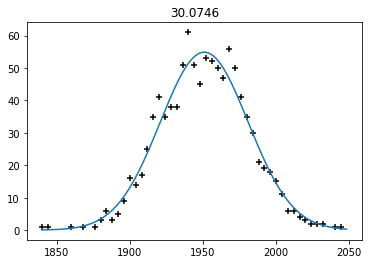

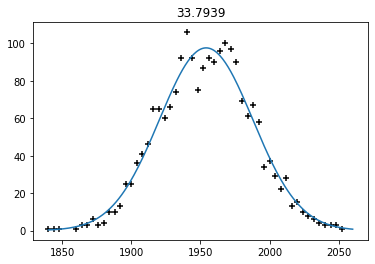

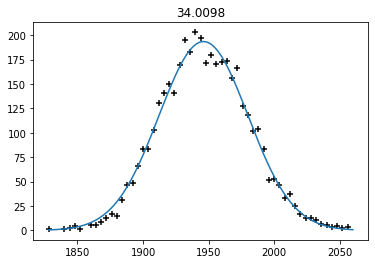

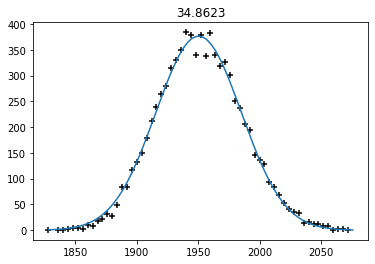

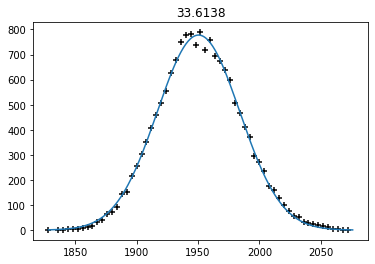

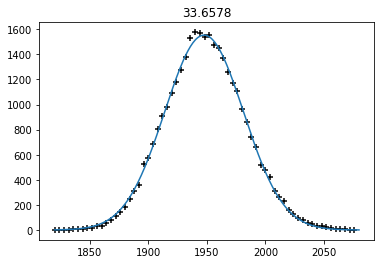

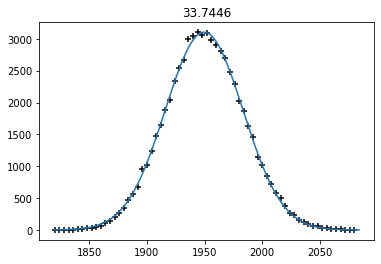

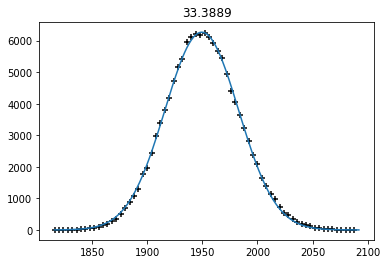

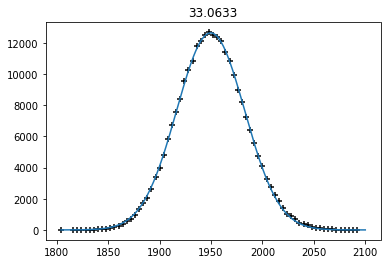

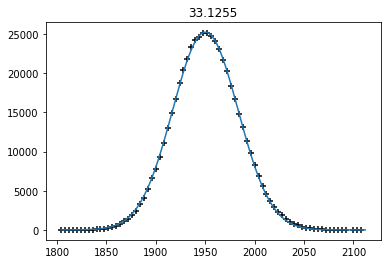

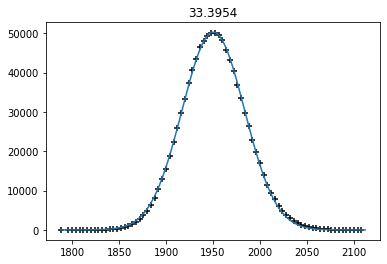

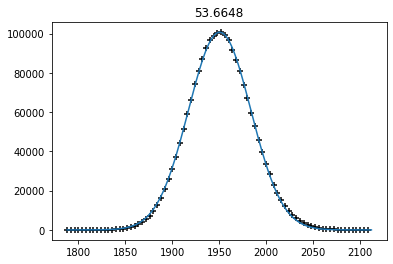

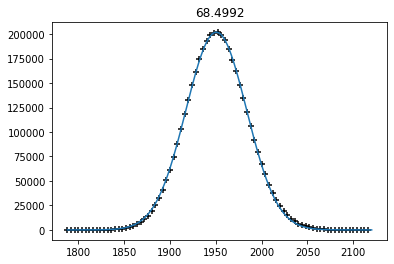

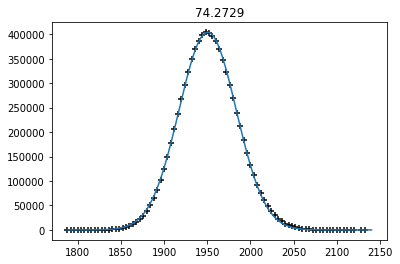

In [15]:
fits = []
formulas = []

for i in range( len( data ) ):
    chunks = data[i][3]
    x = np.arange( min( chunks ), max( chunks ) + 1 )
    h, _ = np.histogram( chunks, bins= x - 0.5 )

    def Gauss(x, A, mu, s):
        y = A*np.exp(-0.5 * ( ( x - mu ) / s )**2 )
        return y
    (A, mu, s), errs = curve_fit( Gauss, x[:-1][h>0], h[h>0], p0 = [ np.sum(h), np.mean(chunks), np.std(chunks) ])

    fits.append( s )
    formulas.append( np.std( chunks ) )

    plt.figure()
    plt.scatter( x[:-1][h>0], h[h>0], marker='+', color='k' )
    plt.plot( x, Gauss( x, A, mu, s ) )
    plt.title( str( data[i][1] ) )
    plt.show()

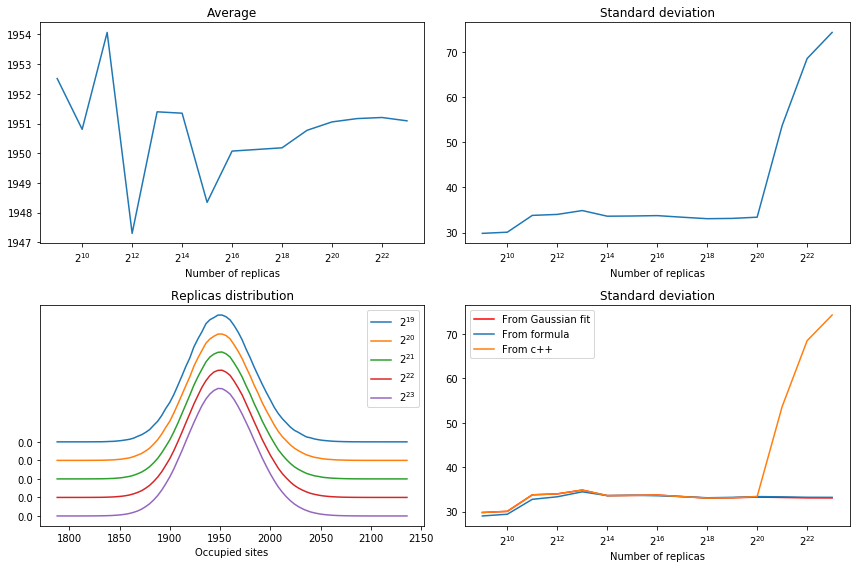

In [17]:
# fits = []
# adv_fits = []

# def Gauss(x, A, mu, s):
#     y = A*np.exp(-0.5 * ( ( x - mu ) / s )**2 )
#     return y

# for i in range( len(hists)):
#     (A, mu, s), _ = curve_fit(Gauss, bins, hists[i], p0 = [ 1, computed_avg()[i], data[i][1] ])
#     fits.append( s )

# step  = 4
# def AdvGauss(x, A, mu, s):
#     y = A*( norm.cdf( ( x - mu + step/2 ) / s ) - norm.cdf( ( x - mu - step/2 ) / s ) )
#     return y

# for i in range( len(hists)):
#     (A, mu, s), _ = curve_fit(AdvGauss, bins, hists[i], p0 = [ 1, computed_avg()[i], data[i][1] ])
#     adv_fits.append( s )

plot_init( 2, 2 )


def computed_avg():
    return [ np.mean( d[3] ) for d in data ]

plt.semilogx( datac(0), computed_avg(), basex = 2 )
plt.title( 'Average' )
plt.xlabel("Number of replicas")

plot_next();

plt.semilogx( datac(0), datac(1), basex = 2 )
plt.title("Standard deviation")
plt.xlabel("Number of replicas")

plot_next()

howmany = 5

for i_d,d in enumerate( data ):
    if( i_d < len( data ) - howmany ):
        continue
    plt.plot( bins, hists[i_d]+ ( len(data) - i_d - 1 ) * 0.007, label=rf"$2^{{{ np.log2(d[0]):.0f}}}$" )

plt.title("Replicas distribution")
plt.xlabel("Occupied sites")
plt.legend()
plt.yticks( np.arange(howmany) * 0.007, np.zeros(howmany) )

plot_next()

plt.semilogx( datac(0), fits, 'r', basex = 2, label = "From Gaussian fit" )
plt.semilogx( datac(0), formulas, basex = 2, label = "From formula" )
plt.semilogx( datac(0), datac(1), basex = 2, label = "From c++" )
plt.legend()
plt.title("Standard deviation")
plt.xlabel("Number of replicas")
plt.tight_layout()

plt.savefig("SomePlots.pdf")